[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 8ms/step


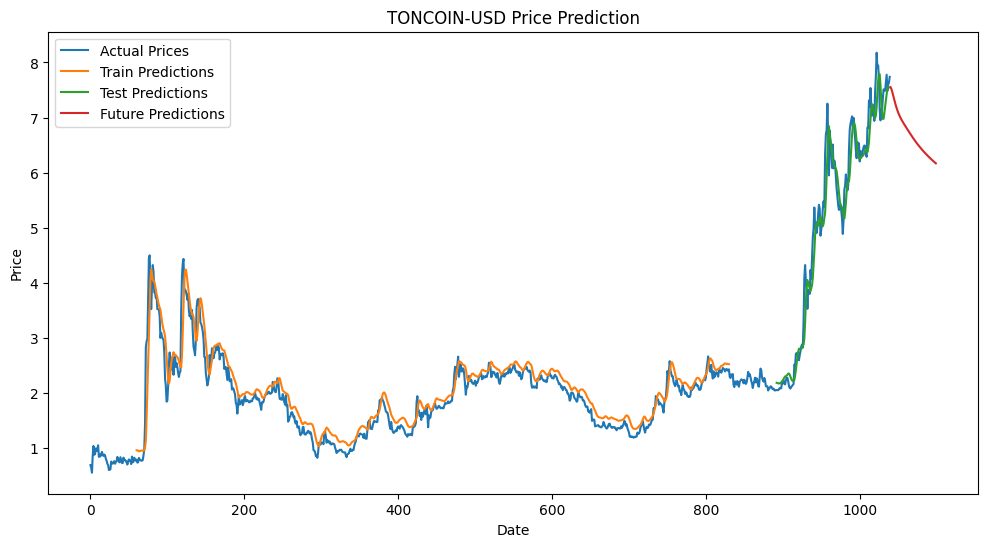

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import plot_model
import yfinance as yf

import matplotlib.pyplot as plt

# Fetch data from Yahoo Finance
ticker = 'TON11419-USD'
data = yf.download(ticker, start='2010-01-01', end='2024-07-02')

# Prepare the data for training
data = data['Close'].values.reshape(-1, 1)

# Scale the data to be in the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create dataset matrix for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for I in range(len(data) - time_step - 1):
        a = data[I:(I + time_step), 0]
        X.append(a)
        Y.append(data[I + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1))) # First LSTM layer with 50 units
model.add(LSTM(50, return_sequences=False)) # Second LSTM layer with 50 units
model.add(Dense(25)) # Dense layer with 25 units
model.add(Dense(1)) # Output layer with 1 unit

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Visualize the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Predict 60 days into the future
future_predictions = []
current_batch = test_data[-time_step:].reshape(1, time_step, 1)

for _ in range(60):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

future_predictions = scaler.inverse_transform(future_predictions)

# Plot the results
# Shift train predictions for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline, predictions, and future predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Prices')
plt.plot(train_plot, label='Train Predictions')
plt.plot(test_plot, label='Test Predictions')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + 60), future_predictions, label='Future Predictions')
plt.title('TONCOIN-USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()